# **Frames**

This notebook demonstrates how to use **SigmaEpsilon** to calculate 3d frames, and provides with some comparison to other parametric modelling frameworks.

## Input Data

In [1]:
Lx, Ly, Lz = 40., 12., 8.
nx, ny, nz = 8, 4, 4

D = 0.1  # outer diameter of the tube
t = 0.05  # thickness of the tube
F = 100.0

nCase = 15


In [2]:
from sigmaepsilon.mesh.space import StandardFrame, PointCloud
from dewloosh.mesh.grid import gridH8 as grid
from dewloosh.mesh.topo.tr import H8_to_L2
import numpy as np

# mesh
gridparams = {
    'size': (Lx, Ly, Lz),
    'shape': (8, 4, 4),
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)
coords, topo = H8_to_L2(coords, topo)

GlobalFrame = StandardFrame(dim=3)

points = PointCloud(coords, frame=GlobalFrame).centralize()
dx = - np.array([points[:, 0].min(), 0., 0.])
points.move(dx)
coords = points.show()


In [3]:
from dewloosh.core import DeepDict
from time import time

summary = DeepDict()


## AxisVM

In [4]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)
axvm


IAxisVMApplication,Information
AxisVM Platform,64 bit
AxisVM Version,15 r4q En 0
Type Library Version,15 401


In [5]:
import axisvm.com.tlb as axtlb

# create new model
modelId = axvm.Models.New()
axm = axvm.Models[modelId]

# material
ndc, material = axtlb.ndcEuroCode, "S 235"
axm.Settings.NationalDesignCode = ndc

# cross section
MaterialIndex = axm.Materials.AddFromCatalog(ndc, material)
CrossSectionIndex = axm.CrossSections.AddCircleHollow('S1', D, t)

# crate nodes
fnc = axm.Nodes.Add
list(map(lambda c: fnc(*c), coords))

# create lines
fnc = axm.Lines.Add
GeomType = axtlb.lgtStraightLine
list(map(lambda x: fnc(x[0], x[1], GeomType), topo + 1))

# set material and cross section
LineAttr = axtlb.RLineAttr(
    LineType=axtlb.ltBeam,
    MaterialIndex=MaterialIndex,
    StartCrossSectionIndex=CrossSectionIndex,
    EndCrossSectionIndex=CrossSectionIndex
)
lineIDs = [i+1 for i in range(axm.Lines.Count)]
attributes = [LineAttr for _ in range(axm.Lines.Count)]
axm.Lines.BulkSetAttr(lineIDs, attributes)

# essential boundary conditions
spring = axtlb.RStiffnesses(x=1e12, y=1e12, z=1e12, xx=1e12, yy=1e12, zz=1e12)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(x=0, y=0, z=0, xx=0, yy=0, zz=0)
ebcinds = np.where(coords[:, 0] < 1e-12)[0]
for i in ebcinds:
    axm.NodalSupports.AddNodalGlobal(spring, RNonLinearity, RResistances, i+1)

# natural boundary conditions
load_cases = {}
LoadCaseType = axtlb.lctStandard
inds = np.where(coords[:, 0] > Lx - 1e-12)[0] + 1
axm.BeginUpdate()
for case in range(nCase):
    name = 'LC{}'.format(case+1)
    lcid = axm.LoadCases.Add(name, LoadCaseType)
    pid = np.random.choice(inds)
    Fx, Fy, Fz = 0, 0, -F
    force = axtlb.RLoadNodalForce(
        LoadCaseId=lcid,
        NodeId=pid,
        Fx=Fx, Fy=Fy, Fz=Fz,
        Mx=0., My=0., Mz=0.,
        ReferenceId=0
    )
    axm.Loads.AddNodalForce(force)
    load_cases[lcid] = dict(name=name, id=case)
    summary['AxisVM', name] = DeepDict(lcid=lcid, fid=pid, f=[Fx, Fy, Fz])
axm.EndUpdate()

fpath = 'console_H8_L2.axs'
axm.SaveToFile(fpath, False)
summary['AxisVM', 'path'] = fpath
axm


IAxisVMModel,Information
N Nodes,225
N Lines,560
N Members,560
N Surfaces,0
N Domains,0


In [6]:
t0 = time()
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)
dt = time() - t0
summary['AxisVM', 'proc', 'time'] = dt


In [7]:
nIDs = [i+1 for i in range(axm.Nodes.Count)]
disps = axm.Results.Displacements
disps.DisplacementSystem = axtlb.dsGlobal
for lcid, lcdata in load_cases.items():
    lcname = lcdata['name']
    dofsol_case = np.zeros((axm.Nodes.Count, 3))
    disps.LoadCaseId = lcid
    disps.LoadLevelOrModeShapeOrTimeStep = 1
    def fnc(i): return disps.NodalDisplacementByLoadCaseId(i)[0].ex
    dofsol_case[:, 0] = np.array(list(map(fnc, nIDs)))
    def fnc(i): return disps.NodalDisplacementByLoadCaseId(i)[0].ey
    dofsol_case[:, 1] = np.array(list(map(fnc, nIDs)))
    def fnc(i): return disps.NodalDisplacementByLoadCaseId(i)[0].ez
    dofsol_case[:, 2] = np.array(list(map(fnc, nIDs)))
    summary['AxisVM', lcname, 'dofsol'] = np.copy(dofsol_case)


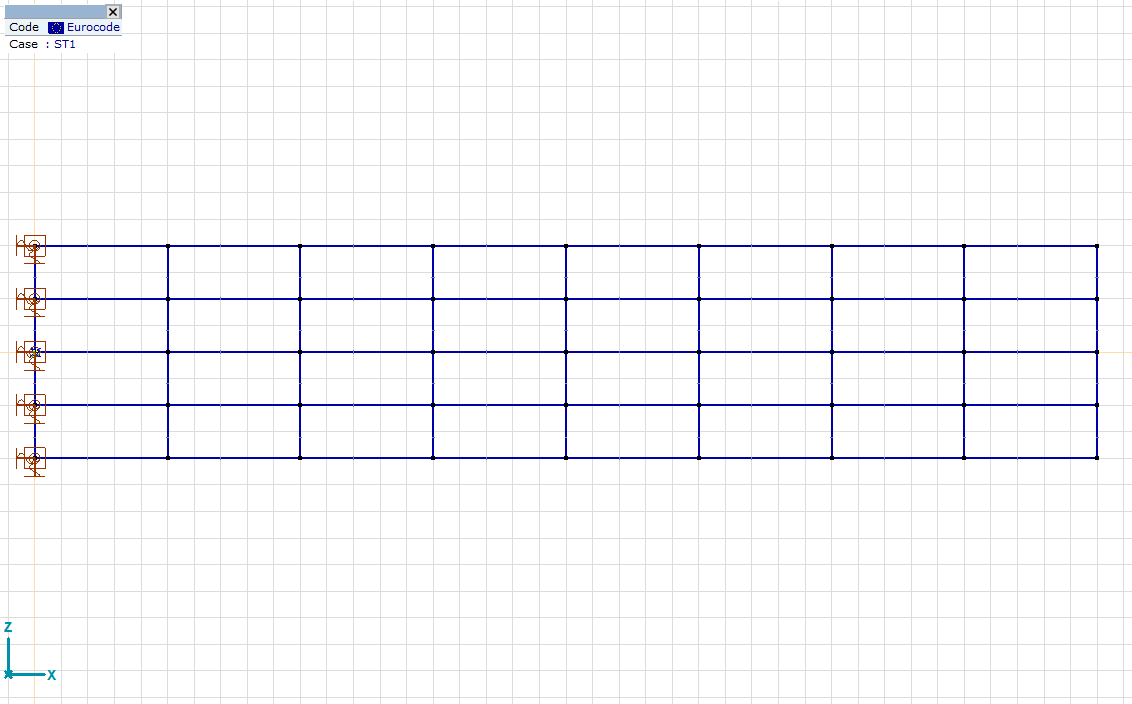

In [8]:
axm.View = axtlb.vFront
axvm.MainFormTab = axtlb.mftGeometry
axm.FitInView()
axm.Windows[1].screenshot()


In [9]:
# we want the domain to fill up the screen entirely
axm.View = axtlb.vFront
axvm.MainFormTab = axtlb.mftStatic
axm.FitInView()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=False,
    Surfaces=False,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmDiagram,
    DisplayShape=axtlb.dsDeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCombination
)

axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, 2, [])

axm.Windows.ReDraw()
axvm.BringToFront()


1

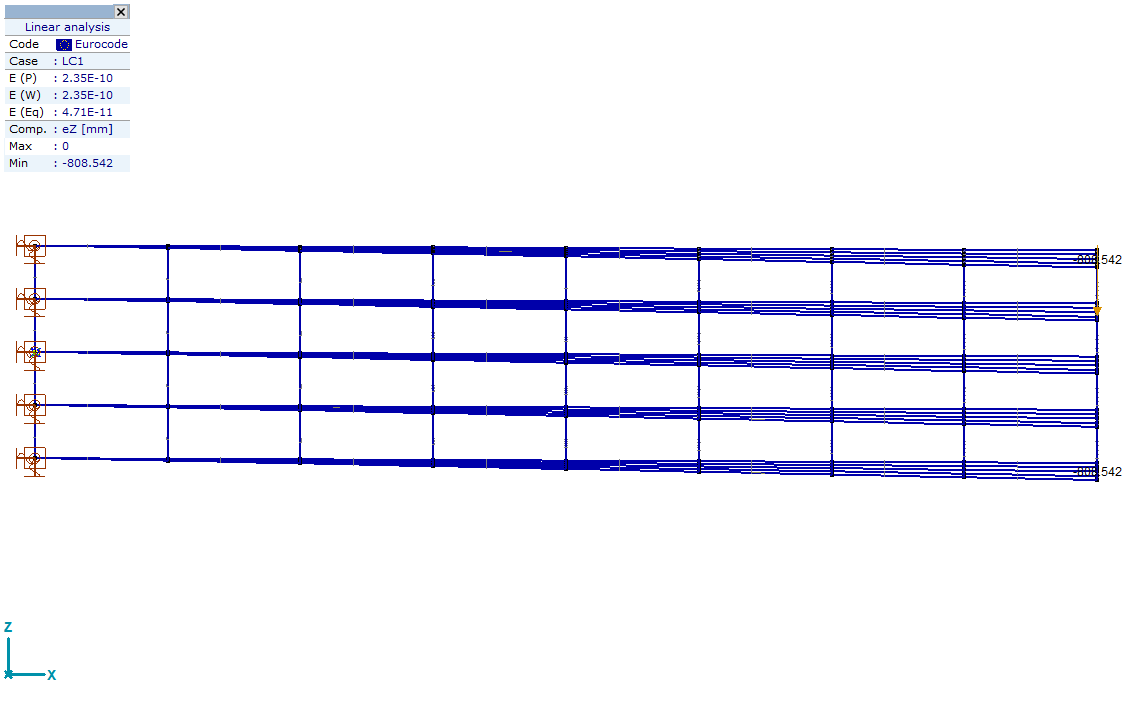

In [10]:
axm.Windows[1].screenshot()


## AxisVM Experimental

In [11]:
coords = axm.coords()
topo_members = axm.Members.topology()


## SigmaEpsilon

In [12]:
from sigmaepsilon import Structure, LineMesh, PointData
from sigmaepsilon.mesh.space import StandardFrame, frames_of_lines
from sigmaepsilon.fem.cells import B2 as Beam
import numpy as np

# model stiffness matrix
material = axm.Materials.Item[MaterialIndex]
E, nu = material.Ex, material.Nux
section = axm.CrossSections.Item[CrossSectionIndex]
A, Iy, Iz, Ix = section.Ax, section.Iy, section.Iz, section.Iyz
G = E / (2 * (1 + nu))
Hooke = np.array([
    [E*A, 0, 0, 0],
    [0, G*Ix, 0, 0],
    [0, 0, E*Iy, 0],
    [0, 0, 0, E*Iz]
])

# space
GlobalFrame = StandardFrame(dim=3)

# essential boundary conditions
ebcinds = np.where(coords[:, 0] < 1e-12)[0]
fixity = np.zeros((coords.shape[0], 6)).astype(bool)
fixity[ebcinds, :] = True

# natural boundary conditions
loads = np.zeros((coords.shape[0], 6, nCase))
for lcdata in load_cases.values():
    lcname = lcdata['name']
    id = lcdata['id']
    fid = summary['AxisVM', lcname, 'fid'] - 1
    f = summary['AxisVM', lcname, 'f']
    loads[fid, :len(f), id] = f
loads = loads.reshape(coords.shape[0] * 6, nCase)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = frames_of_lines(coords, topo)
cd = Beam(topo=topo, frames=frames)

# set up mesh and structure
mesh = LineMesh(pd, cd, model=Hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)


In [13]:
t0 = time()
structure.linsolve(summary=True)
dt = time() - t0
summary['SigEps', 'proc', 'time'] = dt


In [14]:
dofsol = structure.nodal_dof_solution()[:, :3, :]

for lcdata in load_cases.values():
    lcname = lcdata['name']
    id = lcdata['id']
    summary['SigEps', lcname, 'dofsol'] = dofsol[:, :, id]


In [15]:
from dewloosh.core.tools import float_to_str_sig
from dewloosh.math.array import minmax
def f4(v): return float_to_str_sig(v, sig=4)


load_case_names = list(load_cases.values())

diffs = []
for lcdata in load_cases.values():
    lcname = lcdata['name']
    id = lcdata['id']
    r_axvm = summary['AxisVM', lcname, 'dofsol'].min()
    r_sigeps = summary['SigEps', lcname, 'dofsol'].min()
    diffp = 100 * np.abs(r_axvm - r_sigeps) / \
        np.min(np.abs([r_axvm, r_sigeps]))
    diffs.append(diffp)
print('min : {} % \nmax : {} %'.format(
    *list(map(f4, minmax(np.array(diffs))))))


min : 0.03568 % 
max : 6.042 %


In [16]:
t_sigeps = summary['SigEps', 'proc', 'time']
t_axvm = summary['AxisVM', 'proc', 'time']
t_axvm / t_sigeps


0.7488702987264614

# **Plotting**

## Plotly

In [17]:
mesh.plot_dof_solution(case=0)


### Plotly with JupyterDash

This requires ``jupyter-dash`` to be installed!

In [18]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
from dewloosh.mesh.plotting.plotly import plot_lines_3d

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Plotly | JupyterDash"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return mesh.plot_dof_solution(case=0)


# Run app and display result inline in the notebook
app.run_server(mode='inline')


### Plotly with JupyterDash and VTK

This requires ``dash-vtk`` to be installed!

In [ ]:
from jupyter_dash import JupyterDash
from dash import html

import dash_vtk
from dash_vtk.utils import to_mesh_state

# Use VTK to get some data
ugrid = mesh.to_vtk()
mesh_state = to_mesh_state(ugrid)
vtk_content = dash_vtk.View([
    dash_vtk.GeometryRepresentation(
        children=[dash_vtk.Mesh(state=mesh_state)],
        property={
            "lineWidth ": 10,
            "representation": 1,
            "edgeColor": (0, 0, 0),
            "color": (1, 1, 1),
            "edgeVisibility ": True
        },
    ),
],
    background=[1, 1, 1])

# Build App
app = JupyterDash(__name__)
app.layout = html.Div(
    style={"width": "100%", "height": "400px"},
    children=[
        html.H1("Plotly | JupyterDash | VTK"),
        vtk_content
    ],
)

# Run app and display result inline in the notebook
app.run_server(mode='inline')
